In [7]:
%matplotlib widget
from copy import deepcopy
import numpy as np

import SimpleITK as sitk
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

import torch
from segment_anything import sam_model_registry

from extensions.text_prompt import TextPromptEncoder, MedSAMText,TextPromptDemo

## Load pre-trained model

Two models should be loaded:
- the pre-trained MedSAM model
- The text encoder and fine-tuned mask decoder

In [8]:
medsam_ckpt_path = "../../work_dir/MedSAM/medsam_vit_b.pth"
medsam_text_demo_checkpoint = "../../work_dir/MedSAM/medsam_text_prompt_flare22.pth"
device = "cuda:0"

medsam_model = sam_model_registry['vit_b'](checkpoint=medsam_ckpt_path)
text_prompt_encoder = TextPromptEncoder(
    embed_dim = 256,
    image_embedding_size = (64, 64),
    input_image_size = (1024, 1024),                                                            
    mask_in_chans = 1
)
medsam_text_demo = MedSAMText(
    image_encoder=deepcopy(medsam_model.image_encoder),
    mask_decoder=deepcopy(medsam_model.mask_decoder),
    prompt_encoder=text_prompt_encoder,
    device = device
)
medsam_text_demo_weights = torch.load(medsam_text_demo_checkpoint)
for key in medsam_text_demo.state_dict().keys():
    if not key.startswith('prompt_encoder.text_encoder.'):
        medsam_text_demo.state_dict()[key].copy_(medsam_text_demo_weights[key])
medsam_text_demo = medsam_text_demo.to(device)
medsam_text_demo.eval()

MedSAMText(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()

# Original Demo

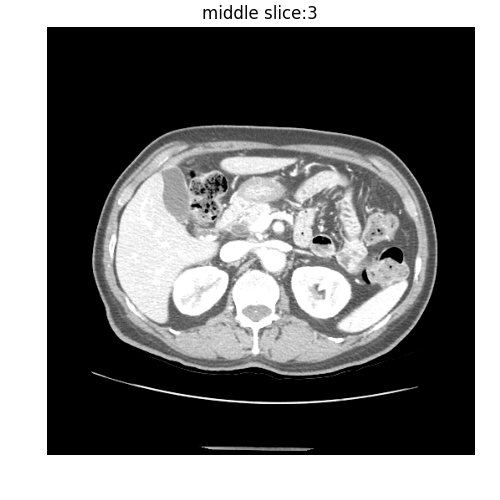

Text(0.5, 1.0, 'middle slice:46')

In [20]:
# load demo nii data
demo_file_nii = "../../work_dir/FLARE22_Tr_0046_0000.nii.gz"
file_sitk = sitk.ReadImage(demo_file_nii)
image_data = sitk.GetArrayFromImage(file_sitk) #slice first, then x, y
# adjust window width and level
lower_bound = -240.0
upper_bound = 160.0
image_data_pre = np.clip(image_data, lower_bound, upper_bound)
# normalise to [0, 255]
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre = np.uint8(image_data_pre)
# select middle slice; you can also manually select the slice that you want to test
image_slice_id = int(image_data_pre.shape[0]/2)
image_slice = image_data_pre[image_slice_id]
# show the image to check whether it contains abdominal organs
plt.imshow(np.rot90(image_slice, 2), cmap='grey')
plt.show()
plt.title('middle slice:'+str(image_slice_id))

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Possible prompts: liver, right kidney, spleen, pancreas, aorta, inferior vena cava, ivc, right adrenal gland, rag, left adrenal gland, lag, gallbladder, esophagus, stomach, duodenum, left kidney


Text(value='', description='Enter a prompt', placeholder='Prompt', style=TextStyle(description_width='initial'…

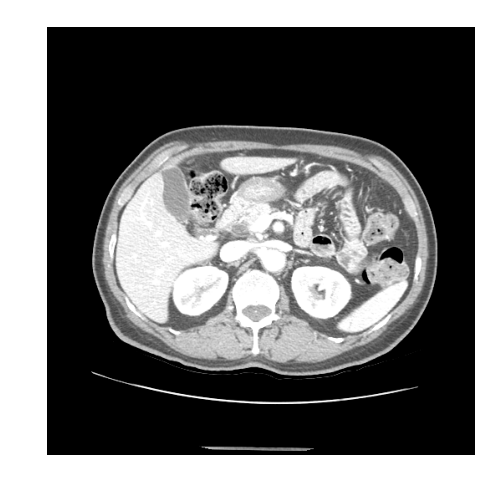

In [11]:
text_prompt_demo = TextPromptDemo(medsam_text_demo)
text_prompt_demo.set_image(image_slice)
text_prompt_demo.show()

# Let's try on our data

### F20204 Liver ShMoLLI

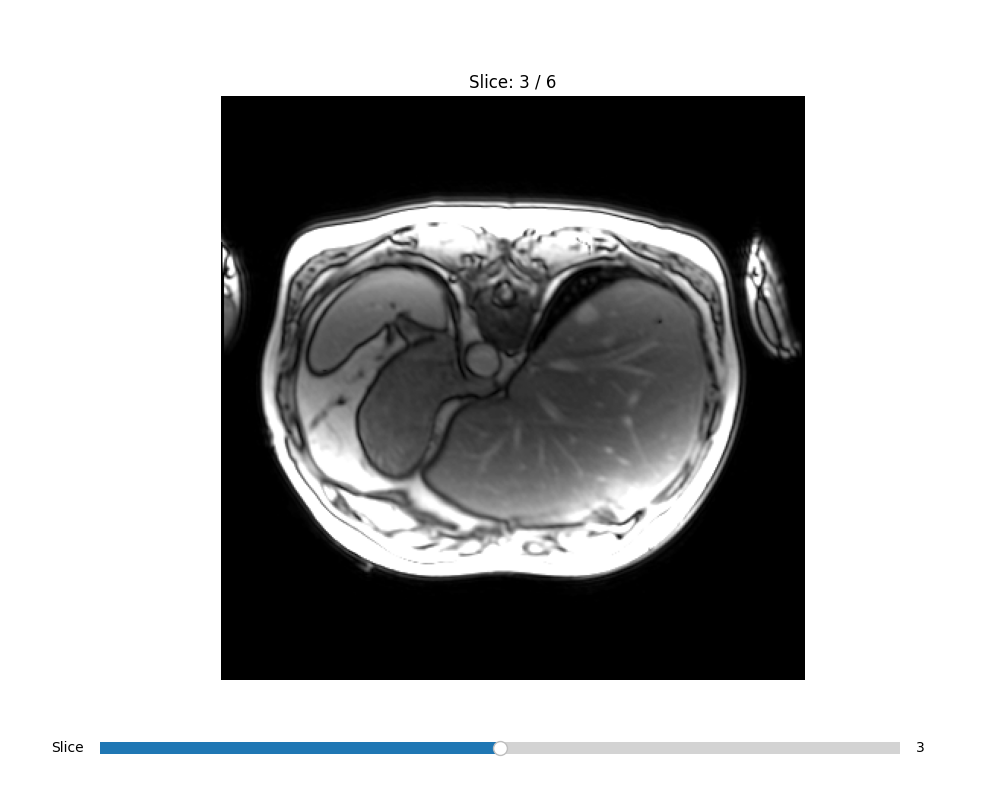

In [ ]:
pth = "/group/glastonbury/soumick/toysets/dummy_F20204_Liver_Imaging_T1_ShMoLLI_DICOM_H5v3/exported_images/NIFTI/4466184_20204_2_0_primary_0.nii.gz"

file_sitk = sitk.ReadImage(pth)
image_data = sitk.GetArrayFromImage(file_sitk) #channel (or slice in 3D cases) first, then x, y

# Check if the last 2 dimensions are not identical and pad to make it a perfect square
height, width = image_data.shape[-2], image_data.shape[-1]
if height != width:
    # Calculate padding needed to make it square
    max_dim = max(height, width)
    pad_height = max_dim - height
    pad_width = max_dim - width
    
    # Apply padding to the last two dimensions
    if len(image_data.shape) == 2:
        # 2D image
        image_data = np.pad(image_data, 
                            ((pad_height//2, pad_height - pad_height//2), 
                            (pad_width//2, pad_width - pad_width//2)), 
                            mode='constant', constant_values=0)
    elif len(image_data.shape) == 3:
        # 3D image (multiple slices)
        image_data = np.pad(image_data, 
                            ((0, 0), 
                            (pad_height//2, pad_height - pad_height//2), 
                            (pad_width//2, pad_width - pad_width//2)), 
                            mode='constant', constant_values=0)

# normalise to [0, 255]

# # Method 0: Simple normalisation with Min/Max scaling
# image_data_pre = (image_data - np.min(image_data))/(np.max(image_data)-np.min(image_data))*255.0
# image_data_pre = np.uint8(image_data_pre)

# Method 1: Window/Level adjustment (like CT/MRI viewing)
lower_percentile = 1
upper_percentile = 95
lower_bound = np.percentile(image_data[image_data > 0], lower_percentile) if np.any(image_data > 0) else 0
upper_bound = np.percentile(image_data, upper_percentile)
image_data_windowed = np.clip(image_data, lower_bound, upper_bound)
image_data_pre = (image_data_windowed - lower_bound) / (upper_bound - lower_bound) * 255.0
image_data_pre = np.uint8(image_data_pre)

# Check if this is a 3D image (multiple slices) or 2D
if len(image_data_pre.shape) > 2 and image_data_pre.shape[0] > 1:
    # Multiple slices - create interactive slider plot
    
    # Close any existing figures to avoid conflicts
    plt.close('all')
    
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.subplots_adjust(bottom=0.15)
    
    # Initial slice (middle)
    image_slice_id = int(image_data_pre.shape[0]/2)
    image_slice = image_data_pre[image_slice_id]
    
    # Display initial image
    im = ax.imshow(np.rot90(image_slice, 2), cmap='gray', vmin=0, vmax=255)
    ax.set_title(f'Slice: {image_slice_id} / {image_data_pre.shape[0]-1}')
    ax.axis('off')
    
    # Create slider
    ax_slider = plt.axes([0.1, 0.05, 0.8, 0.03])
    slider = Slider(ax_slider, 'Slice', 0, image_data_pre.shape[0]-1, 
                   valinit=image_slice_id, valfmt='%d', valstep=1)
    
    def update_slice(val):
        slice_idx = int(slider.val)
        current_slice = image_data_pre[slice_idx]
        im.set_array(np.rot90(current_slice, 2))
        im.set_clim(vmin=0, vmax=255)
        ax.set_title(f'Slice: {slice_idx} / {image_data_pre.shape[0]-1}')
        plt.draw()
    
    slider.on_changed(update_slice)
    plt.show()
    
    # Set the current slice for later use
    image_slice_id = int(image_data_pre.shape[0]/2)
    image_slice = image_data_pre[image_slice_id]
else:
    # Single slice - display normally
    plt.close('all')
    
    if len(image_data_pre.shape) == 3:
        image_slice = image_data_pre[0]
        image_slice_id = 0
    else:
        image_slice = image_data_pre
        image_slice_id = 0
    
    plt.figure(figsize=(10, 8))
    plt.imshow(np.rot90(image_slice, 2), cmap='gray')
    plt.title(f'Image slice: {image_slice_id}')
    plt.axis('off')
    plt.show()


Set 2D image with shape: (384, 384)
Possible prompts: liver, right kidney, spleen, pancreas, aorta, inferior vena cava, ivc, right adrenal gland, rag, left adrenal gland, lag, gallbladder, esophagus, stomach, duodenum, left kidney


Text(value='', description='Enter a prompt', placeholder='Prompt', style=TextStyle(description_width='initial'…

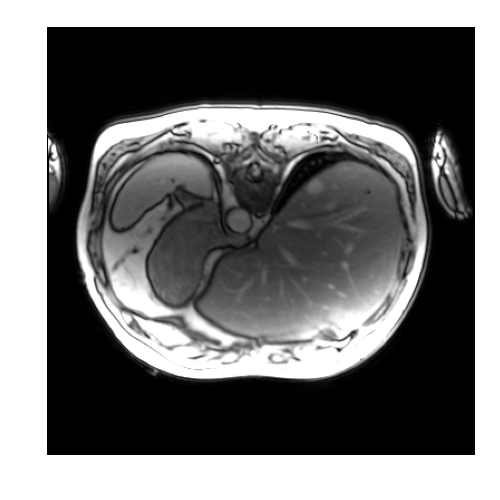

In [5]:
# 2D segmentation, only the central slice (original)
text_prompt_demo = TextPromptDemo(medsam_text_demo)
text_prompt_demo.set_image(image_slice)
text_prompt_demo.show()

Set 3D volume with shape: (7, 384, 384)
Computing embeddings for all slices...
Computed embeddings for 7 slices
Possible prompts: liver, right kidney, spleen, pancreas, aorta, inferior vena cava, ivc, right adrenal gland, rag, left adrenal gland, lag, gallbladder, esophagus, stomach, duodenum, left kidney


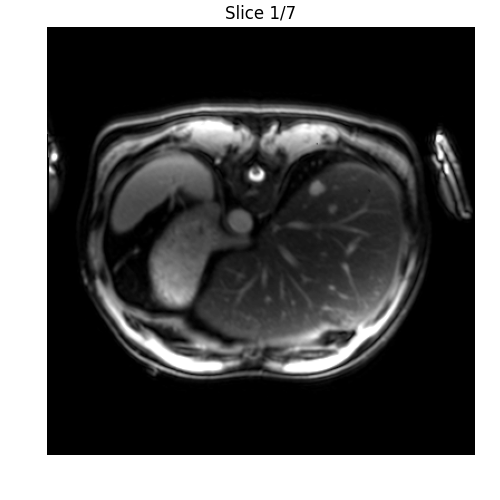

In [11]:
# 3D segmentation, extended functionality
text_prompt_demo = TextPromptDemo(medsam_text_demo)
text_prompt_demo.set_image(image_data_pre)
text_prompt_demo.show()

In [17]:
image_data.shape

(7, 288, 384)